# ArXiv Semantic Graph – Project Demo

This notebook demonstrates the main steps of our pipeline:

1. Exploratory Data Analysis (EDA)
2. Embeddings (Universal Sentence Encoder)
3. HNSW index for fast nearest neighbours
4. Distance histogram and global threshold τ
5. Semantic graph construction
6. Graph clustering (Louvain communities)
7. Semantic recommendation demo


## Section 0 - Imports and paths

In [7]:
from pathlib import Path
import sys

ROOT = Path("..").resolve()
sys.path.append(str(ROOT))

from src.arxiv_semantic_graph import eda, embeddings, graph, graph_clustering, recommend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = ROOT / "data" / "arxiv-metadata-oai-snapshot.json"
OUTPUTS = ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)

## Section 1 - EDA

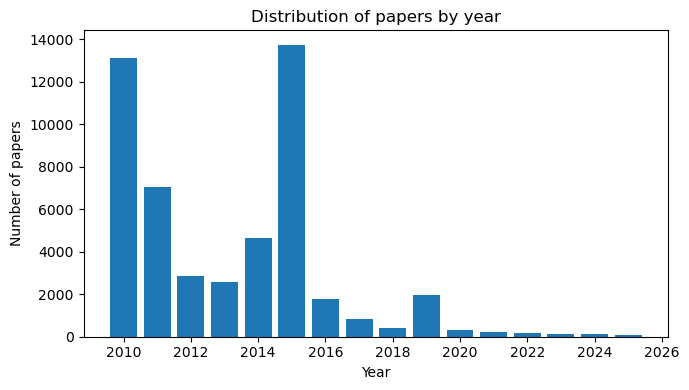

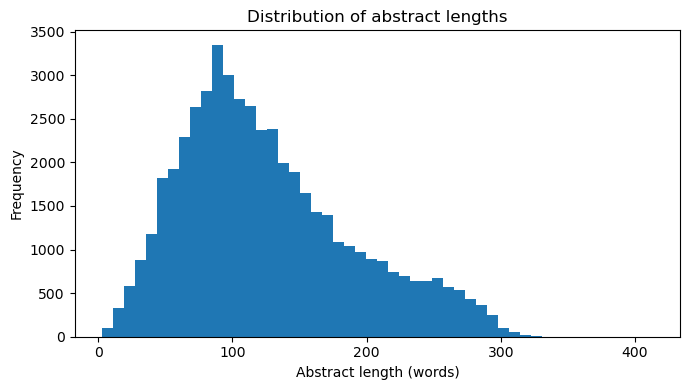

In [8]:
years, lengths = eda.load_eda_data(
    file_path=str(DATA_PATH),
    max_papers=50000,
    min_year=2010,
)

stats = eda.compute_eda_stats(years, lengths)

eda.plot_year_distribution(years, save_path=None, show=True)
eda.plot_length_distribution(lengths, save_path=None, show=True)

## Section 2 -Embeddings

In [9]:
EMB_DIR = OUTPUTS / "embeddings"
EMB_DIR.mkdir(exist_ok=True)

total_embedded = embeddings.create_embeddings(
    file_path=str(DATA_PATH),
    out_dir=str(EMB_DIR),
    batch_size=64,
    shard_size=25000,
    min_year=2010,
)

AttributeError: module 'src.arxiv_semantic_graph.embeddings' has no attribute 'create_embeddings'

## Section 3 - HNSW

In [ ]:
HNSW_DIR = OUTPUTS / "hnsw"
HNSW_DIR.mkdir(exist_ok=True)

index, N, D = hnsw_index.build_or_load_hnsw(
    emb_dir=str(EMB_DIR),
    index_dir=str(HNSW_DIR),
    space="cosine",
    ef_construction=200,
    M=16,
    ef_search=100,
    num_threads=8,
)

## Section 4 — Distance histogram & τ

In [ ]:
GRAPH_OUT = OUTPUTS / "graphs"
GRAPH_OUT.mkdir(exist_ok=True)

hist_info = graph.compute_knn_distance_histogram(
    index=index,
    emb_dir=str(EMB_DIR),
    k=6,
    sample_size=100000,
    out_dir=str(GRAPH_OUT),
)

## Section 5 — Graph construction

In [ ]:
results_tau = []

for tau in tau_candidates:
    edge_path = graph.build_graph_for_tau(
        index=index,
        emb_dir=str(EMB_DIR),
        tau=tau,
        k_for_search=50,
        out_dir=str(GRAPH_OUT),
    )
    stats_tau = graph.compute_graph_stats(
        edge_path=edge_path,
        num_nodes=N,
    )
    stats_tau["tau"] = tau
    stats_tau["edge_path"] = edge_path
    results_tau.append(stats_tau)


## Section 6 - Louvain communities

In [ ]:
tau_star = tau_candidates[1]
edge_path_star = [r["edge_path"] for r in results_tau if r["tau"] == tau_star][0]

CLUSTER_OUT = OUTPUTS / "clustering"
CLUSTER_OUT.mkdir(exist_ok=True)

louvain_result = graph_clustering.run_louvain(
    edge_path=edge_path_star,
    num_nodes=N,
    out_dir=str(CLUSTER_OUT),
)

## Section 7 - Recomendation demo

In [ ]:
meta = recommend.load_metadata(str(EMB_DIR))

recs = recommend.recommend_random(
    index=index,
    emb_dir=str(EMB_DIR),
    metadata=meta,
    k=5,
    tau=tau_star,
    louvain_labels=louvain_result["labels"],
)